# Alchemical PES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
plt.rcParams['figure.figsize'] = [7, 5]
plt.rcParams['font.size'] = 12

from apdft_tools.utils import *
from apdft_tools.prediction import *
from apdft_tools.data import prepare_dfs
from apdft_tools.analysis import get_alchemical_errors

json_path = '../../json-data/atom-pyscf.apdft-data.posthf.json'
df_qc, df_apdft = prepare_dfs(json_path, get_CBS=False)

## Alchemical PES system specifications

In [2]:
n_electrons = 7
excitation_level = 0
sys_type = 'atom'
basis_set = 'aug-cc-pV5Z'

### Parity plot

Text(0, 0.5, 'Alchemical Energy (Ha)')

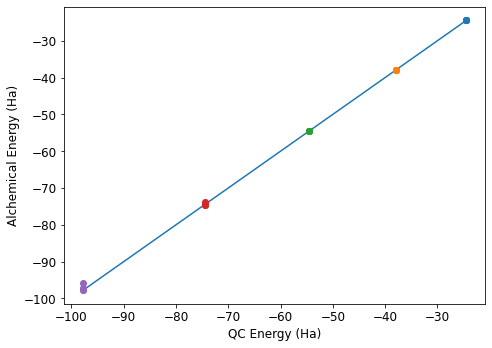

In [3]:
return_energies = True

state_labels, all_energies = get_alchemical_errors(
    df_qc, n_electrons, excitation_level=excitation_level,
    basis_set=basis_set, return_energies=return_energies
)

system_labels = [state_label.split('.')[0] for state_label in state_labels]

fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.patch.set_facecolor('white')

# Plot energies.
parity_line = []
for i in range(len(system_labels)):
    true_energy = all_energies[i,i]
    parity_line.append(true_energy)

    energies = np.delete(all_energies[i,:], i)
    x = [true_energy for j in range(len(energies))]
    ax.scatter(x, energies)

# Plot parity line
ax.plot(parity_line, parity_line, zorder=0)

ax.set_xlabel('QC Energy (Ha)')

ax.set_ylabel('Alchemical Energy (Ha)')

### PES

Text(0, 0.5, 'Alchemical Energy (Ha)')

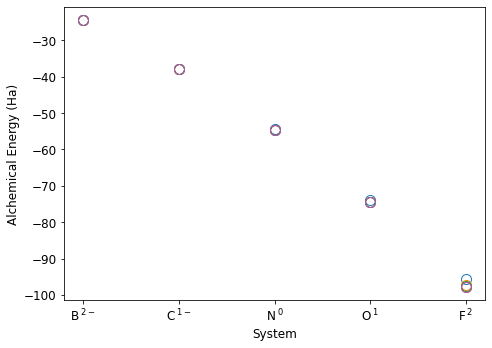

In [4]:
return_energies = True

state_labels, all_energies = get_alchemical_errors(
    df_qc, n_electrons, excitation_level=excitation_level,
    basis_set=basis_set, return_energies=return_energies
)

system_labels_condensed = []
for state_label in state_labels:
    split = state_label.split('.')
    sys_label = split[0].capitalize()
    charge = str(split[1][4:])
    if charge[0] == '-':
        charge = charge[1] + '-'
    system_labels_condensed.append(sys_label + '$\,^{' + charge + '}$')

###   FIGURE   ###
fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.patch.set_facecolor('white')

# Plot energies.
parity_line = []
for i in range(len(system_labels_condensed)):
    true_energy = all_energies[i,i]
    parity_line.append(true_energy)

    energies = all_energies[:,i]
    x = [i for i in range(0, len(energies))]
    ax.plot(
        x, energies,
        marker='o',
        markersize=10,
        fillstyle='none',
        markeredgewidth=1,
        linestyle='',
        label=system_labels[i]
    )

ax.set_xlabel('System')
ax.set_xticks([i for i in range(len(system_labels_condensed))])
ax.set_xticklabels(system_labels_condensed)

ax.set_ylabel('Alchemical Energy (Ha)')

### Lollipop

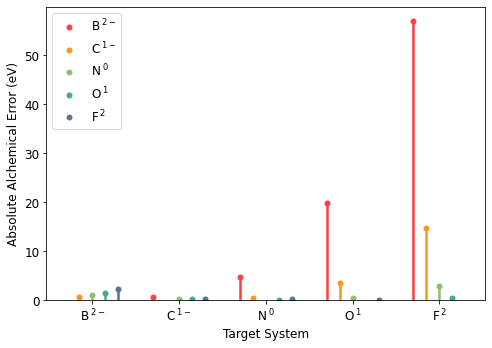

In [5]:
return_energies = False

state_labels, all_energies = get_alchemical_errors(
    df_qc, n_electrons, excitation_level=excitation_level,
    basis_set=basis_set, return_energies=return_energies
)

system_labels_condensed = []
for state_label in state_labels:
    split = state_label.split('.')
    sys_label = split[0].capitalize()
    charge = str(split[1][4:])
    if charge[0] == '-':
        charge = charge[1] + '-'
    system_labels_condensed.append(sys_label + '$\,^{' + charge + '}$')

marker_size = 5
line_width = 2.5
j_offset = 0.15

fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.patch.set_facecolor('white')
sys_colors = [
    '#F94144', '#F8961E', '#90BE6D', '#43AA8B', '#577590'
]

for i in range(len(system_labels_condensed)):
    energies = hartree_to_ev(np.abs(all_energies[i,:]))

    x = [i+j*j_offset for j in range(i+len(energies))]
    for j in range(len(system_labels_condensed)):
        if i == j and i != 0:
            color = 'white'
        else:
            color = sys_colors[j]
        
        ax.plot(
            [x[j], x[j]], [0, energies[j]],
            marker='', markersize=0, 
            linestyle='-', linewidth=line_width,
            color=color
        )
        if i == 0:
            ax.plot(
                x[j], energies[j],
                marker='o', markersize=marker_size, 
                linestyle='', linewidth=0,
                color=color, label=system_labels_condensed[j]
            )
            if j == 0:
                ax.plot(
                x[j], energies[j],
                marker='o', markersize=marker_size+2, 
                linestyle='', linewidth=0,
                color='white', markeredgecolor='white'
            )
        else:
            ax.plot(
                x[j], energies[j],
                marker='o', markersize=marker_size, 
                linestyle='', linewidth=0,
                color=color
            )


ax.set_xlabel('Target System')
xlabel_offset = ((len(system_labels)-1)/2)*j_offset
xlabel_spacing = [i+xlabel_offset for i in range(len(system_labels))]
ax.set_xticks(xlabel_spacing)
ax.set_xticklabels(system_labels_condensed)

ax.set_ylabel('Absolute Alchemical Error (eV)')
fig.gca().set_ylim(bottom=0)

ax.legend()


## APDFT*n* prediction of alchemical PES

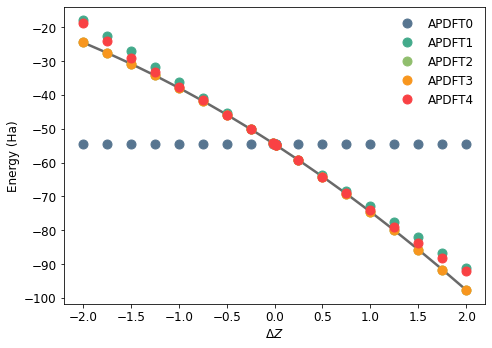

In [6]:
ref_charge = 0  # From -2 to 2.

df_qc_sys = df_qc.query(
    'n_electrons == @n_electrons'
    '& charge == @ref_charge'
    '& basis_set == @basis_set'
)
sys_multiplicity = get_multiplicity(df_qc_sys, excitation_level)
df_qc_sys = df_qc_sys.query('multiplicity == @sys_multiplicity')

df_apdft_sys = df_apdft.query(
    'n_electrons == @n_electrons'
    '& charge == @ref_charge'
    '& basis_set == @basis_set'
    '& multiplicity == @sys_multiplicity'
)
poly_coeffs = df_apdft_sys.iloc[0]['poly_coeff']

lambda_sort = np.argsort(df_qc_sys['lambda_value'].values)

lambda_values = df_qc_sys['lambda_value'].values[lambda_sort]
e_qc = df_qc_sys['electronic_energy'].values[lambda_sort]
e_apdft = np.zeros((len(poly_coeffs), len(lambda_values)))

for order in range(len(poly_coeffs)):
    e_apdft[order] = np.array(
        [calc_apdft_pred(poly_coeffs, order, l_value)[0] for l_value in lambda_values]
    )

###   FIGURE   ###
fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.patch.set_facecolor('white')

order_colors = [
    '#577590', '#43AA8B', '#90BE6D', '#F8961E', '#F94144'
]

# Alchemical PES
ax.plot(
    lambda_values, e_qc,
    color='dimgrey', linewidth=2.5,
    #label='Alchemy'
)

for order in range(len(poly_coeffs)):
    ax.plot(
        lambda_values, e_apdft[order],
        color=order_colors[order],
        marker='o', markersize=9, fillstyle='full',
        linestyle='', label=f'APDFT{order}'
    )

ax.set_xlabel('$\Delta Z$')

ax.set_ylabel('Energy (Ha)')

ax.legend(frameon=False)

### Heatmaps

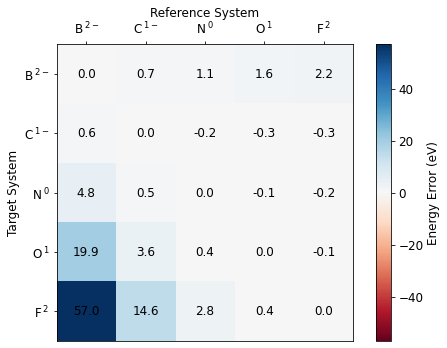

In [7]:
# PES
return_energies = True
state_labels, energy_errors = get_alchemical_errors(
    df_qc, n_electrons, excitation_level=excitation_level,
    basis_set=basis_set
)
system_labels_condensed = []
for state_label in state_labels:
    split = state_label.split('.')
    sys_label = split[0].capitalize()
    charge = str(split[1][4:])
    if charge[0] == '-':
        charge = charge[1] + '-'
    system_labels_condensed.append(sys_label + '$\,^{' + charge + '}$')

# Heatmap with error.
energy_errors = hartree_to_ev(energy_errors)
fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.patch.set_facecolor('white')
max_abs_error = np.max(np.abs(energy_errors.flatten()))
end_buffer = 0

divnorm=colors.TwoSlopeNorm(
    vmin=-max_abs_error-end_buffer, vcenter=0., vmax=max_abs_error+end_buffer
)
img = ax.imshow(
    energy_errors, cmap='RdBu', norm=divnorm
)

for (j,i),error in np.ndenumerate(energy_errors):
    ax.text(i, j, f'{error:.1f}', ha='center', va='center')

ax.set_xlabel('Reference System')
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.set_xticks(range(0, len(system_labels_condensed)))
ax.set_xticklabels(system_labels_condensed)

ax.set_ylabel('Target System')
ax.set_yticks(range(0, len(system_labels_condensed)))
ax.set_yticklabels(system_labels_condensed)

fig.colorbar(img, label='Energy Error (eV)')